In [8]:
import pickle
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt

# Loading and Fixing data

Read pickle data file. Remove unwanted features and drop rows containing NaN values. Replace action feature by binary features action_heating and action_cooling. 

In [9]:
class ProcessingData:
    
    def __init__(self,filepath):
        with open(filepath, 'rb') as f:
            u = pickle._Unpickler(f)
            u.encoding = 'latin1'
            self.data = u.load()
    '''
    def add_last_temperature_feature(self):
        """Adding a feature which specifies what the previous temperature was "dt" seconds before the current
        datasample. Since data does not need be continious, we need a loop.
        :param: pd.df with cols: "t_in", "dt" and needs to be sorted by time.
        returns pd.df with cols "t_last" added. """

        last_temps = []

        last_temp = None
        curr_time = self.data.index[0]
        for index, row in self.data.iterrows():

            if last_temp is None:
                last_temps.append(row["t_in"])  # so the feature will be zero instead
            else:
                last_temps.append(last_temp)

            if curr_time == index:
                last_temp = row["t_in"]
                curr_time += datetime.timedelta(minutes=row["dt"])
            else:
                last_temp = None
                curr_time = index + datetime.timedelta(minutes=row["dt"])

        self.data["t_last"] = np.array(last_temps)
        return self.data
    '''

    def fix_data(self, interval):
        """Fixes up the data. Makes sure we count two stage as single stage actions, don't count float actions,
        converts action duration and dt to floats, fill's nan's in action_duration and drops all datapoints which
        don't have dt equal to interval.
        :param data:
        :param interval: float:minutes"""
        def f(x):
            if x == 0:
                return 0
            elif x == 2 or x == 5:
                return 2
            elif x ==1 or x == 3:
                return 1

        def h(x):
            if x == 1:
                return 1
            else:
                return 0

        def c(x):
            if x == 2:
                return 1
            else:
                return 0

        self.data["action"] = self.data["action"].map(f)
        self.data['action_heating'] = self.data["action"].map(h)
        self.data['action_cooling'] = self.data['action'].map(c)

        #print self.data.head()

        return self.data, self.data[self.data["dt"] == interval]
    
    def filter_data(self):
        self.data = self.data.drop(['dt', 'action', 'previous_action', 'action_duration', \
                                    'zone_temperatureHVAC_Zone_Shelter_Corridor'], axis=1)
        return self.data
    
    def drop_nan(self):
        self.data = self.data.dropna()
        return self.data
    '''
    def getTarget(self, target):
        y = self.data[target]
        return y
    
    def getFeatures(self, target):
        X = self.data.drop([target], axis=1)
        return X
    '''
    
    

# Training data

In [10]:
training = ProcessingData("../Data/avenal-animal-shelter_training_data.pkl")
training_data = training.fix_data(5)
training_data = training.filter_data()
training_data = training.drop_nan()

# Testing data

In [11]:
testing = ProcessingData("../Data/avenal-animal-shelter_test_data.pkl")
testing_data = testing.fix_data(5)
testing_data = testing.filter_data()
testing_data = testing.drop_nan()

# Importing libraries for LSTM

In [12]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Convert Time series data to Supervised data

In [14]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
    data: Sequence of observations as a list or NumPy array.
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
    Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Scaling training data

In [15]:
train_values = training_data.values
# integer encode direction
encoder = LabelEncoder()
train_values[:,4] = encoder.fit_transform(train_values[:,4])
# ensure all data is float
train_values = train_values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_values)

In [16]:
# frame as supervised learning
train_reframed = series_to_supervised(train_scaled, 1, 1)
train_reframed.drop(train_reframed.columns[[7,8,9,10,11]], axis=1, inplace=True)
train_reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t)
1,0.407016,0.540116,0.368630,0.0,0.0,0.0,0.407016
2,0.407016,0.540776,0.368630,0.0,0.0,0.0,0.407016
3,0.407016,0.540776,0.368981,0.0,0.0,0.0,0.401904
4,0.401904,0.540776,0.370034,0.0,0.0,0.0,0.407016
5,0.407016,0.536817,0.371438,0.0,0.0,0.0,0.401904


In [17]:
training_data.head()

,t_next,t_in,t_out,occ,action_heating,action_cooling
time,,,,,,
2018-04-18 23:16:42+00:00,69.5,69.483333,66.499700,0.0,0,0
2018-04-18 23:21:42+00:00,69.5,69.500000,66.499700,0.0,0,0
2018-04-18 23:26:42+00:00,69.5,69.500000,66.520546,0.0,0,0
2018-04-18 23:31:42+00:00,69.4,69.500000,66.583083,0.0,0,0
2018-04-18 23:36:42+00:00,69.5,69.400000,66.666466,0.0,0,0


In [18]:
test_values = testing_data.values
# integer encode direction
encoder = LabelEncoder()
test_values[:,4] = encoder.fit_transform(test_values[:,4])
# ensure all data is float
test_values = test_values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
test_scaled = scaler.fit_transform(test_values)
test_reframed = series_to_supervised(test_scaled, 1, 1)
test_reframed.drop(test_reframed.columns[[7,8,9,10,11]], axis=1, inplace=True)
test_reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t)
1,0.941785,0.941785,0.565371,0.0,0.0,0.0,0.944373
2,0.944373,0.941785,0.565919,0.0,0.0,0.0,0.944373
3,0.944373,0.944373,0.566463,0.0,0.0,0.0,0.944373
4,0.944373,0.944373,0.566996,0.0,0.0,0.0,0.944373
5,0.944373,0.944373,0.567524,0.0,0.0,0.0,0.944373


# Split Targets and Features

Splits the train and test sets into input and output variables. Finally, the inputs (X) are reshaped into the 3D format expected by LSTMs, namely [samples, timesteps, features].

In [19]:
# split into input and outputs
train = train_reframed.values
test = test_reframed.values
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(53185, 1, 6) (53185,) (13389, 1, 6) (13389,)


# LSTM model

In [20]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Train on 53185 samples, validate on 13389 samples
Epoch 1/50
 - 7s - loss: 0.0526 - val_loss: 0.1600
Epoch 2/50
 - 3s - loss: 0.0219 - val_loss: 0.0754
Epoch 3/50
 - 3s - loss: 0.0092 - val_loss: 0.0453
Epoch 4/50
 - 3s - loss: 0.0080 - val_loss: 0.0429
Epoch 5/50
 - 3s - loss: 0.0073 - val_loss: 0.0380
Epoch 6/50
 - 3s - loss: 0.0069 - val_loss: 0.0351
Epoch 7/50
 - 3s - loss: 0.0067 - val_loss: 0.0321
Epoch 8/50
 - 3s - loss: 0.0066 - val_loss: 0.0328
Epoch 9/50
 - 3s - loss: 0.0066 - val_loss: 0.0308
Epoch 10/50
 - 3s - loss: 0.0065 - val_loss: 0.0318
Epoch 11/50
 - 3s - loss: 0.0065 - val_loss: 0.0311
Epoch 12/50
 - 3s - loss: 0.0064 - val_loss: 0.0303
Epoch 13/50
 - 3s - loss: 0.0063 - val_loss: 0.0302
Epoch 14/50
 - 3s - loss: 0.0061 - val_loss: 0.0315
Epoch 15/50
 - 3s - loss: 0.0060 - val_loss: 0.0313
Epoch 16/50
 - 3s - loss: 0.0063 - val_loss: 0.0319
Epoch 17/50
 - 3s - loss: 0.0062 - val_loss: 0.0320
Epoch 18/50
 - 3s - loss: 0.0060 - val_loss: 0.0339
Epoch 19/50
 - 3s - los

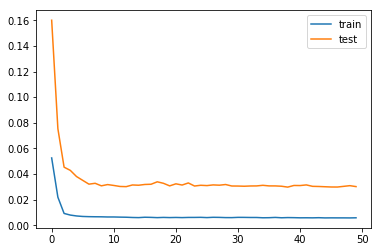

In [21]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Evaluate LSTM model

In [22]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2.481
